In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import numpy as np
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

# Reproducibility
import scvi
from scvi.external import SysVI

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/sysVI/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.1

In [2]:
adata = sc.read_h5ad('./adata_all_mergedHVG_CAPS.h5ad')
adata

AnnData object with n_obs × n_vars = 433583 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    layers: 'counts', 'log1p_norm'

In [3]:
columns_to_drop = ['system', 'n_counts']
adata.obs.drop(columns=columns_to_drop, inplace=True)

In [4]:
adata.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,...,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism
GTATTTCGTCCACATA-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0.0,0,adult,None,None,-0.039946,excitatory neurons,10X 3p kit v3.1,sn,mouse
ATACCTTGTCGACGCT-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0.0,0,adult,None,None,-0.030285,inhibitory neurons,10X 3p kit v3.1,sn,mouse
TCAAGACGTGCTGCAC-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0.0,0,adult,None,None,0.002119,excitatory neurons,10X 3p kit v3.1,sn,mouse
AGTACTGTCAAGTAAG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0.0,0,adult,None,None,0.039672,excitatory neurons,10X 3p kit v3.1,sn,mouse
TCCCAGTTCCGATGCG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0.0,0,adult,None,None,-0.016213,inhibitory neurons,10X 3p kit v3.1,sn,mouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind102-Sample4:TTTGTTGAGCGACTGA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.059753,oligodendrocytes,10X 3p kit v3.3,sn,human
Ind102-Sample4:TTTGTTGAGTAGCTCT-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.037903,microglia,10X 3p kit v3.3,sn,human
Ind102-Sample4:TTTGTTGCAGACGATG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.052304,microglia,10X 3p kit v3.3,sn,human
Ind102-Sample4:TTTGTTGCATACAGAA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.023288,oligodendrocytes,10X 3p kit v3.3,sn,human


In [5]:
mapping = {'(this study)': 0, 'Pandey et al. 2022': 1, 'Shen et al. 2021': 1, 'Macnair et al. biorxiv': 2}

# Map the values in 'mm_study' column to create the new 'sysvi' column
adata.obs["system"] = adata.obs["publication"].map(mapping)
adata.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,...,age_scale,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism,system
GTATTTCGTCCACATA-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0,adult,None,None,-0.039946,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
ATACCTTGTCGACGCT-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0,adult,None,None,-0.030285,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0
TCAAGACGTGCTGCAC-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0,adult,None,None,0.002119,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
AGTACTGTCAAGTAAG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0,adult,None,None,0.039672,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
TCCCAGTTCCGATGCG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,...,0,adult,None,None,-0.016213,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind102-Sample4:TTTGTTGAGCGACTGA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.059753,oligodendrocytes,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGAGTAGCTCT-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.037903,microglia,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGCAGACGATG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.052304,microglia,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGCATACAGAA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,...,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.023288,oligodendrocytes,10X 3p kit v3.3,sn,human,2


In [6]:
system_counts = adata.obs['system'].value_counts()

# Create a DataFrame to display the counts
system_counts_df = pd.DataFrame({'system': system_counts.index, 'Count': system_counts.values})
system_counts_df

,system,Count
0,2,321566
1,1,90634
2,0,21383


In [7]:
counts_by_publication_system = adata.obs.groupby('publication')['system'].value_counts()
counts_by_publication_system

/tmp/140611.1.gpu-long/ipykernel_721371/3886540734.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_publication_system = adata.obs.groupby('publication')['system'].value_counts()


publication             system
(this study)            0          21383
                        1              0
                        2              0
Macnair et al. biorxiv  2         321566
                        0              0
                        1              0
Pandey et al. 2022      1          41938
                        0              0
                        2              0
Shen et al. 2021        1          48696
                        0              0
                        2              0
Name: count, dtype: int64

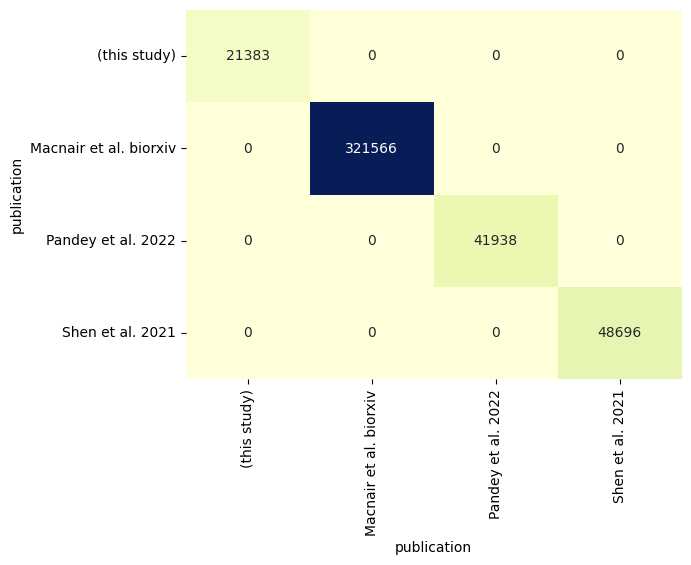

In [8]:
crosstab_df = pd.crosstab(adata.obs.publication, adata.obs.publication)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

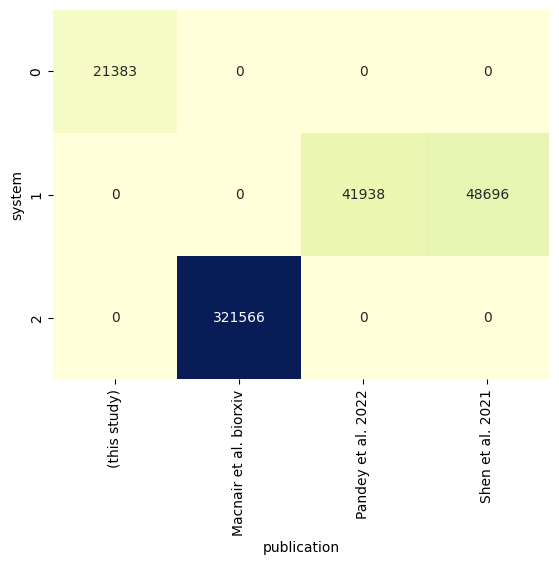

In [9]:
crosstab_df = pd.crosstab(adata.obs.system, adata.obs.publication)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

# Subset for testing

In [10]:
n=33333
adata_sub=adata[np.random.RandomState(seed=0).permutation(adata.obs_names)[:n],:]
pd.crosstab(adata_sub.obs.cell_type_eval,adata_sub.obs.system)

system,0,1,2
cell_type_eval,,,
astrocytes,42,81,2975
b cells,0,0,81
choroid plexus,0,108,0
endo + peri,4,134,620
ependymal,4,8,0
excitatory neurons,154,6,1896
inhibitory neurons,68,0,561
microglia,447,3650,2897
mixed ol + microglia,15,87,0


In [11]:
adata = adata_sub.copy()

In [12]:
adata.var

,human_gene_id,mouse_gene_id,mouse_gene_name,human_gene_name
SNX24,ENSG00000064652,ENSMUSG00000024535,Snx24,SNX24
FAM49A,ENSG00000197872,ENSMUSG00000020589,NaN,FAM49A
KHDRBS3,ENSG00000131773,ENSMUSG00000022332,Khdrbs3,KHDRBS3
MSR1,ENSG00000038945,ENSMUSG00000025044,Msr1,MSR1
CACNA1D,ENSG00000157388,ENSMUSG00000015968,Cacna1d,CACNA1D
...,...,...,...,...
TEAD1,ENSG00000187079,ENSMUSG00000055320,Tead1,TEAD1
KCNK1,ENSG00000135750,ENSMUSG00000033998,Kcnk1,KCNK1
SYNPO2,ENSG00000172403,ENSMUSG00000050315,Synpo2,SYNPO2
SDK2,ENSG00000069188,ENSMUSG00000041592,Sdk2,SDK2


# Initiate model

In [13]:
adata

AnnData object with n_obs × n_vars = 33333 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    layers: 'counts', 'log1p_norm'

In [14]:
print(adata.X[:10, :10])

(0, 6)        1.153626863412006
  (1, 1)        3.542611494100682
  (2, 0)        0.5453521013259888
  (2, 2)        0.5453521013259888
  (2, 4)        0.5453521013259888
  (2, 5)        0.5453521013259888
  (3, 1)        1.3795227639116223
  (3, 2)        2.5566085505385896
  (3, 4)        0.783537114613664
  (3, 7)        0.783537114613664
  (3, 8)        0.4666235624467441
  (4, 0)        0.18521350622177124
  (4, 5)        0.7017980217933655
  (4, 6)        0.7017980217933655
  (4, 7)        0.4764987826347351
  (4, 8)        0.34142476320266724
  (5, 6)        2.0129122734069824
  (6, 0)        2.756793541119736
  (8, 0)        2.670061703369982
  (8, 2)        3.3279712923854086
  (8, 4)        1.7011574241076968
  (8, 5)        2.670061703369982
  (9, 4)        0.7968186868742532
  (9, 5)        1.5380312962507425

In [15]:
# Setup adata for training
SysVI.setup_anndata(
    adata=adata,
    batch_key="system",
    categorical_covariate_keys=["batch"],
)

INFO     Using column names from columns of adata.obsm['system']                                                   
INFO     Using column names from columns of adata.obsm['covariates']                                               


In [16]:
# Initialise the model
model = SysVI(adata=adata)

INFO     The model has been initialized                                                                            


In [17]:
# Train
max_epochs = 200
model.train(
    max_epochs=max_epochs,
    # Parameters used for checking losses
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|█████████████████████████████████████████| 200/200 [15:08<00:00,  4.27s/it, v_num=1, loss_train=-1.75e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█████████████████████████████████████████| 200/200 [15:08<00:00,  4.54s/it, v_num=1, loss_train=-1.75e+3]


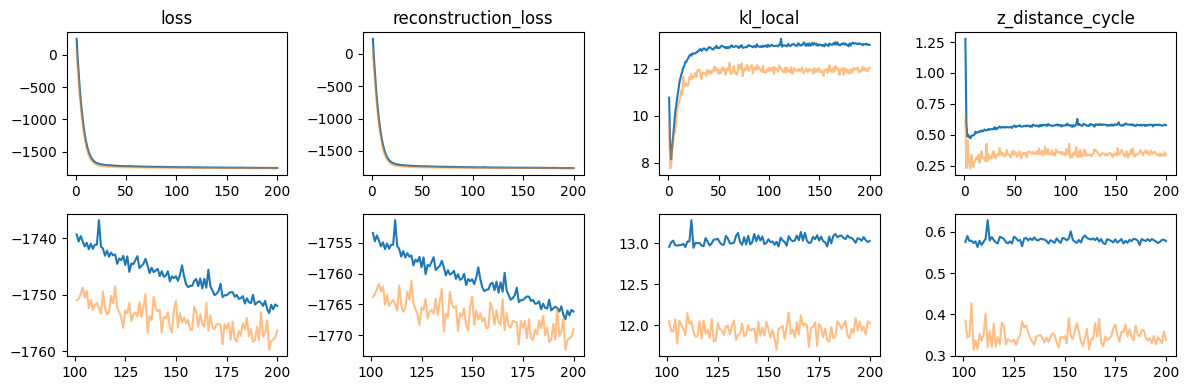

In [18]:
# Plot loses
# The plotting code below was specifcally adapted to the above specified model and its training
# If changing the model or training the plotting functions may need to be addapted accordingly

# Make detailed plot after N epochs
epochs_detail_plot = 100
steps_detail_plot = epochs_detail_plot * int(
    model.trainer.logger.history["loss_validation"].shape[0] / max_epochs
)
detail_plot = epochs_detail_plot

# Losses to plot
losses = [
    "loss_train",
    "reconstruction_loss_train",
    "kl_local_train",
    "z_distance_cycle_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1 so that below adjustment when
    # train on step which only works for val leads to appropriate multiplication
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    # This happens if log on step as currently this works only for val loss
    if l_train_values.shape[0] < l_val_values.shape[0]:
        l_train_values.index = l_train_values.index * int(
            l_val_values.shape[0] / l_train_values.shape[0]
        )
    for l_values, c, alpha, dp in [
        # Train loss logged on epoch in either case now
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(
            l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha
        )

fig.tight_layout()

In [19]:
# Get embedidng - save it into X of new AnnData
embed = model.get_latent_representation(adata=adata)
embed = sc.AnnData(embed, obs=adata.obs)
# Make system categorical for plotting below
embed.obs["sysVI"] = embed.obs["system"].map({0: "mouse-sn", 1: "mouse-sc", 2: "human-sn"})

In [20]:
embed

AnnData object with n_obs × n_vars = 33333 × 15
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'sysVI'

In [21]:
# Compute UMAP
sc.pp.neighbors(embed, use_rep="X")
sc.tl.umap(embed)

In [22]:
embed.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,...,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism,system,sysVI
Ind130-Sample2:GTAGGTTCATCGTGCG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind130-Sample2,Ind130,1,MS_patient,MS,White matter,41 years,82,...,under_50,6H_to_12H,up_to_12H,0.031325,oligodendrocytes,10X 3p kit v3.3,sn,human,2,human-sn
Ind127-Sample4:GCATGATAGGAAAGTG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind127-Sample4,Ind127,1,MS_patient,MS,White matter,40 years,91,...,under_50,6H_to_12H,up_to_12H,-0.070811,microglia,10X 3p kit v3.3,sn,human,2,human-sn
GTAACCACAGAAGTTA-1_pandey_mouse,SRR15622247,Pandey et al. 2022,pandey_Sample9_1,pandey_Sample9,1,No lesion,Control,Corpus callosum,Baseline,9,...,adult,None,None,0.694349,neuroblasts,10X 3p kit v2,sc,mouse,1,mouse-sc
Ind113-Sample1:AAGCGTTTCCCGTAAA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind113-Sample1,Ind113,1,MS_patient,MS,White matter,76 years,54,...,over_70,up_to_6H,up_to_12H,-0.028584,excitatory neurons,10X 3p kit v3.3,sn,human,2,human-sn
GCCAGCATCTTACTGT-1_pandey_mouse,SRR15622247,Pandey et al. 2022,pandey_Sample9_1,pandey_Sample9,1,No lesion,Control,Corpus callosum,Baseline,9,...,adult,None,None,0.056788,oligodendrocytes,10X 3p kit v2,sc,mouse,1,mouse-sc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind146-Sample1:GGGCTACCACTATCCC-1_macnair,Human_MS,Macnair et al. biorxiv,Ind146-Sample1,Ind146,1,MS_patient,MS,White matter,82 years,119,...,over_70,6H_to_12H,up_to_12H,-0.117277,astrocytes,10X 3p kit v3.3,sn,human,2,human-sn
TCAGCTCAGTACCGGA-1_shen_mouse,SRR11546845,Shen et al. 2021,shen_Sample23_1,shen_Sample23,1,Cuprizone,Demyelination,Corpus callosum,4 weeks,23,...,adult,None,None,-0.018484,oligodendrocytes,10X 3p kit v2,sc,mouse,1,mouse-sc
Ind118-Sample2:TCTGCCACACAGTCAT-1_macnair,Human_MS,Macnair et al. biorxiv,Ind118-Sample2,Ind118,1,MS_patient,MS,White matter,66 years,61,...,inbetween,6H_to_12H,up_to_12H,-0.066064,oligodendrocytes,10X 3p kit v3.3,sn,human,2,human-sn
Ind108-Sample2:CGAGGAATCAACCCGG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind108-Sample2,Ind108,1,MS_patient,MS,White matter,47 years,46,...,under_50,6H_to_12H,up_to_12H,-0.006766,oligodendrocytes,10X 3p kit v3.3,sn,human,2,human-sn


/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


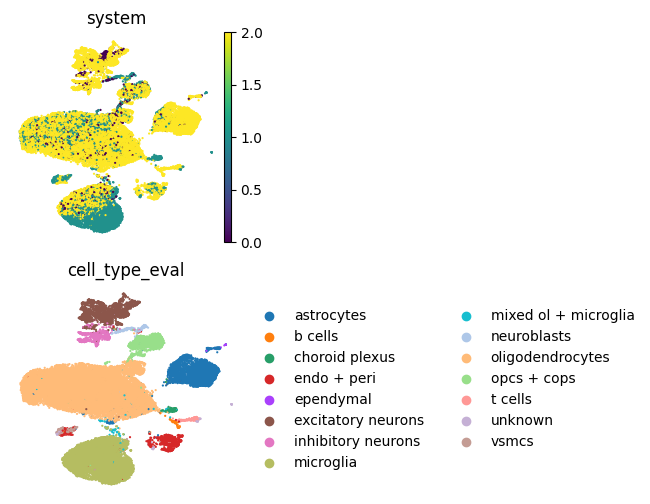

In [23]:
# Plot UMAP embedding

# Obs columns to color by
cols = ["system", "cell_type_eval"]

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

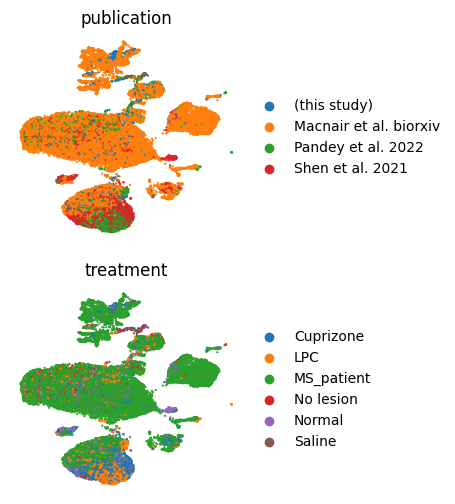

In [25]:
# Plot UMAP embedding

# Obs columns to color by
cols = ["publication", "treatment"]

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/sc

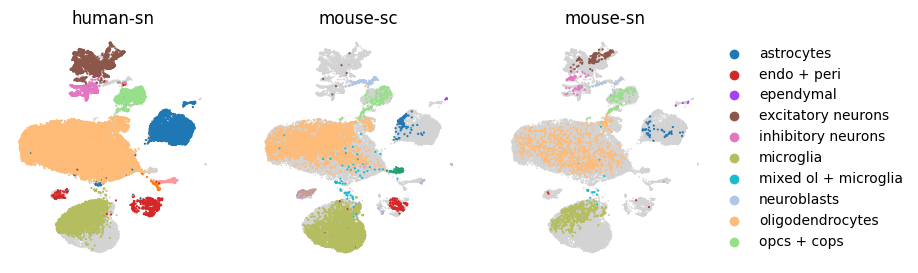

In [24]:
# Plot UMAP embedding per system
systems = sorted(embed.obs.sysVI.unique())
ncols = len(systems)
# Plot systems side by side
fig, axs = plt.subplots(1, ncols, figsize=(3 * ncols, 3))
for i, system in enumerate(systems):
    ax = axs[i]
    # Plot all cells as background and on top cells from one system colored by cell type
    sc.pl.umap(embed, ax=ax, show=False, s=5, frameon=False)
    sc.pl.umap(
        embed[embed.obs.sysVI == system, :],
        color="cell_type_eval",
        ax=ax,
        show=False,
        s=10,
        frameon=False,
        title=system,  # Fix: Use `system` instead of `systems`
    )
    # Keep legend only on the last plot (assuming this legend contains all categories)
    if i != ncols - 1:
        ax.get_legend().remove()

In [27]:
adata

AnnData object with n_obs × n_vars = 33333 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    uns: 'layer_information', 'system_order', 'covariate_categ_orders', 'covariate_key_orders', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'system', 'covariates'
    layers: 'counts', 'log1p_norm'

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

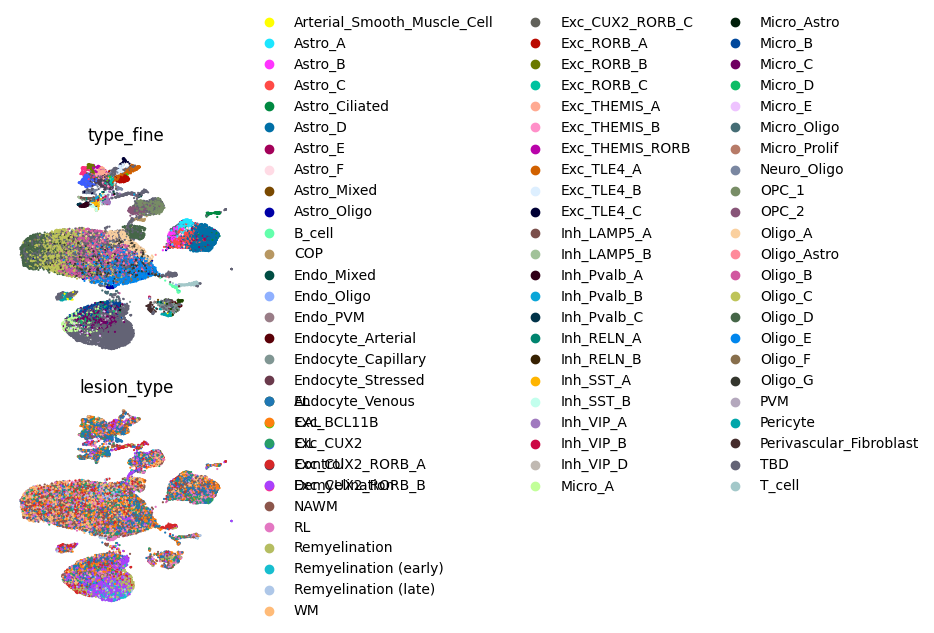

In [30]:
# Plot UMAP embedding

# Obs columns to color by
cols = ["type_fine", "lesion_type"]

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


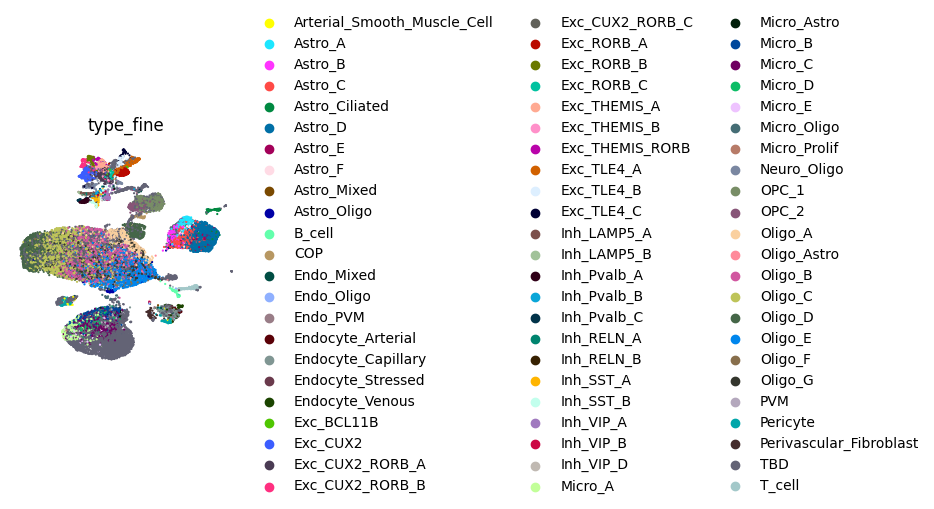

In [34]:
# Obs column to color by
col = "type_fine"

# Plot with color set to "type_fine" column
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.embedding(
    embed,
    "X_umap",
    color=col,
    s=10,
    ax=ax,
    show=True,  # Change to True if you want to display the plot immediately
    sort_order=False,
    frameon=False,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


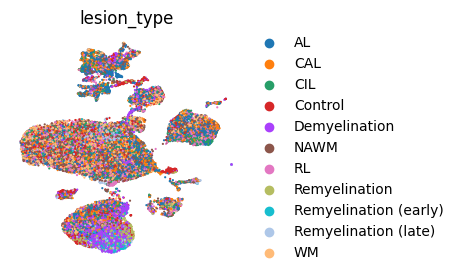

In [35]:
# Obs column to color by
col = "lesion_type"

# Plot with color set to "type_fine" column
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.embedding(
    embed,
    "X_umap",
    color=col,
    s=10,
    ax=ax,
    show=True,  # Change to True if you want to display the plot immediately
    sort_order=False,
    frameon=False,
)